In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

from skopt import gp_minimize
from skopt.space import Integer, Real

tf.keras.backend.set_floatx('float32')

plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif"
})

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

array = np.array
float32 = np.float32
int32 = np.int32
float64 = np.float64
int64 = np.int64

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_lorenz


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v2 import Autoencoder
from tools.ESN_v1 import ESN
from tools.hyper_param_ESN import trainESN_and_return_PH

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-06-19 16:24:30.557691: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-19 16:24:30.558045: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-19 16:24:30.600030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-19 16:24:30.600346: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-19 16:24:30.600622: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
# from numpy import *

# making RNN save directory
dir_name_rnn = os.getcwd() + dir_sep + 'ESN_params_Search'
if not os.path.isdir(dir_name_rnn):
    os.makedirs(dir_name_rnn)

counter = 0
while True:
    dir_check = 'params_search_' + str(counter).zfill(3)
    if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
        counter += 1
    else:
        break

dir_name_rnn = dir_name_rnn + dir_sep + dir_check
os.makedirs(dir_name_rnn)
dir_name_rnn_plots = dir_name_rnn+dir_sep+'plots'
os.makedirs(dir_name_rnn_plots)

# whether to use AE data or just work on raw data
use_ae_data = True # if false, specifying ae_idx will only show which dataset to use

# autoencoder directory
# ae_idx = '046'
# dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_024'.format(ds=dir_sep)

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('use_ae_data : ' + str(use_ae_data) + ', dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/ESN_params_Search/params_search_001
use_ae_data : True, dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae/ae_024
data_dir_idx: 008
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.9058021075578292, lyapunov time : 1.1039938926696777s


In [14]:
positve_lp_idx = np.where(lyapunov_time_arr > 0)[0]
print(positve_lp_idx)

[0]


In [15]:
last_idx = all_data.shape[0]
temp_bia = np.zeros(shape=1+boundary_idx_arr.shape[0], dtype=np.int32)
temp_bia[1:] = boundary_idx_arr
print(temp_bia)
for i in range(boundary_idx_arr.shape[0]-1, -1, -1):
    if not (i in positve_lp_idx):
        print(i)
        num_idxs = last_idx - temp_bia[i+1]
        all_data[temp_bia[i]:temp_bia[i]+num_idxs] = all_data[temp_bia[i+1]:last_idx]
        last_idx = last_idx - (temp_bia[i+1]-temp_bia[i])

[     0 100001]


In [16]:
new_bia = np.empty_like(boundary_idx_arr)
new_bia[:] = boundary_idx_arr
new_pmat = np.empty_like(params_mat)
new_pmat[:, :] = params_mat
counter = 0
bia_counter = boundary_idx_arr.shape[0]
for i in range(boundary_idx_arr.shape[0]):
    if not (i in positve_lp_idx):
        new_bia[i:] -= temp_bia[i+1] - temp_bia[i]
        new_bia[i:bia_counter-1] = new_bia[i+1:bia_counter]
        new_pmat[i:bia_counter-1] = new_pmat[i+1:bia_counter]
        bia_counter -= 1

In [17]:
new_bia = new_bia[0:bia_counter]
new_pmat = new_pmat[0:bia_counter]

In [18]:
all_data = all_data[0:new_bia[-1]]

In [19]:
new_bia, boundary_idx_arr = boundary_idx_arr, new_bia
new_pmat, params_mat = params_mat, new_pmat

In [20]:
# delaing with normalizing the data before feeding into autoencoder
num_params = params_mat.shape[1]
og_vars = all_data.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

if use_ae_data == True:
    if ae_data_with_params == True and alldata_withparams_flag == False:
        new_all_data = np.empty(shape=(all_data.shape[0], og_vars+num_params), dtype=FTYPE)
        new_all_data[:, 0:og_vars] = all_data[:, 0:og_vars]
        del(all_data)
        all_data = new_all_data
        prev_idx = 0
        for i in range(boundary_idx_arr.shape[0]):
            all_data[prev_idx:boundary_idx_arr[i], num_params:] = params_mat[i]
            prev_idx = boundary_idx_arr[i]

    if normalizeforae_flag == True:
        for i in range(all_data.shape[1]):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    if ae_data_with_params == False:
        all_data = all_data[:, 0:og_vars]
else:
    # using raw data, neglecting the params attached (if any)
    all_data = all_data[:, 0:og_vars]

# Autoencoder

In [21]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [22]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [23]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    del(all_data)
else:
    latent_states_all = all_data
num_latent_states = latent_states_all.shape[1]

# ESN

In [24]:
# RNN data parameters
dt_rnn = 0.1
num_input_tsteps = 1000
T_sample_input = num_input_tsteps*dt_rnn
T_sample_output = T_sample_input
T_offset = dt_rnn
normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
normalization_arr = None
stddev_multiplier = 3
skip_intermediate = 'full sample'
noise_type = 'normal' # can be 'uniform' or 'normal'
normalization_type = 'stddev' # can be 'minmax' or 'stddev', if it is
                              # 'minmax' then stddev_multiplier has no effect
ESN_layers_units = [num_latent_states*200]
stateful = True
omega_in_x0 = 1.0
degree_of_connectivity_x0 = 3
rho_res_x0 = 0.8
usebias_Win = [False]
alpha_x0 = 0.99
ESN_cell_activations = ['tanh']
usebias_Wout = True

activation_post_Wout = 'linear'
use_weights_post_dense = False

vary_deg_connect = False # whether to search for degree_of_connectivity or use it as a constant

if return_params_arr != False:
    params = params_arr
else:
    params = None

# saving simulation data
sim_data = {
    'params_mat':params_mat,
    'init_state_mat':init_state_mat,
    't0':t0,
    'T':T,
    'delta_t':delta_t,
    'return_params_arr':return_params_arr,
    'dir_name_ae':dir_name_ae,
    'normalize_dataset':normalize_dataset,
    'stddev_multiplier':stddev_multiplier,
    'use_ae_data':use_ae_data,
    'vary_deg_connect':vary_deg_connect,
}

# saving RNN specific data
RNN_specific_data = {
    'dt_rnn':dt_rnn,
    'T_sample_input':T_sample_input,
    'T_sample_output':T_sample_output,
    'T_offset':T_offset,
    'boundary_idx_arr':boundary_idx_arr,
    'delta_t':delta_t,
    'params':params,
    'return_params_arr':return_params_arr,
    'normalize_dataset':normalize_dataset,
    'num_input_tsteps':num_input_tsteps,
    'stddev_multiplier':stddev_multiplier,
    'skip_intermediate':skip_intermediate,
    'module':ESN.__module__,
    'noise_type':noise_type,
    'normalization_type':normalization_type,
}

In [25]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [26]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [27]:
# setting up training params
num_ensemble_mems = 5
epochs = 1
lambda_reg_x0 = 1e-7 # weight for regularizer
min_delta = 1e-6
patience = 5
train_split = 0.8
val_split = 0.1
test_split = 1 - train_split - val_split
batch_size = 1
fRMS_x0 = 1e-3
use_best = False

# ph computation parameters
num_runs = 100
T_sample_input_AR_ratio = 1
T_sample_output_AR_ratio = 5

# saving training params
training_specific_params = {
    'epochs':epochs,
    'prng_seed':prng_seed,
    'train_split':train_split,
    'val_split':val_split,
    'batch_size':batch_size,
    # 'fRMS':fRMS,
    'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
    # 'stddev':stddev,
    # 'lambda_reg':lambda_reg,
    'min_delta':min_delta,
    'patience':patience,
    'use_best':use_best,
    'degree_of_connectivity_x0':degree_of_connectivity_x0,
}

In [28]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train += int( (1-test_split-val_split)*num_samples )
    num_val += int(val_split*num_samples)
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [num_train]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [num_train]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [num_val]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [num_train]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [cum_samples-num_train-num_val]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [cum_samples-num_train-num_val]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape, dtype=FTYPE)
training_data_rnn_output = np.empty(shape=training_output_shape, dtype=FTYPE)

val_data_rnn_input = np.empty(shape=val_input_shape, dtype=FTYPE)
val_data_rnn_output = np.empty(shape=val_output_shape, dtype=FTYPE)

testing_data_rnn_input = np.empty(shape=testing_input_shape, dtype=FTYPE)
testing_data_rnn_output = np.empty(shape=testing_output_shape, dtype=FTYPE)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    num_samples = idx.shape[0]
    num_train = int( (1-test_split-val_split)*num_samples )
    num_val = int(val_split*num_samples)

    training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val+1
    testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)

# further shuffling
# idx = np.arange(0, training_data_rnn_input.shape[0])
# np.random.shuffle(idx)
# training_data_rnn_input = training_data_rnn_input[idx]
# training_data_rnn_output = training_data_rnn_output[idx]

# idx = np.arange(0, val_data_rnn_input.shape[0])
# np.random.shuffle(idx)
# val_data_rnn_input = val_data_rnn_input[idx]
# val_data_rnn_output = val_data_rnn_output[idx]

# idx = np.arange(0, testing_data_rnn_input.shape[0])
# np.random.shuffle(idx)
# testing_data_rnn_input = testing_data_rnn_input[idx]
# testing_data_rnn_output = testing_data_rnn_output[idx]

# del(idx)

In [29]:
print('training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print(' testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('     val_data_rnn_input.shape : ', val_data_rnn_input.shape)

training_data_rnn_input.shape :  (7, 1000, 2)
 testing_data_rnn_input.shape :  (2, 1000, 2)
     val_data_rnn_input.shape :  (0, 1000, 2)


In [30]:
val_loss_hist = []
train_loss_hist = []

In [31]:
training_data_rnn_input.dtype

dtype('float32')

In [32]:
def optim_func(
        x, # [fRMS, lambda_reg, rho_res, omega_in, alpha, degree_of_connectivity]
        time_stddev=time_stddev,
        og_vars=og_vars,
        ESN=ESN,
        plot_losses=plot_losses,
        dir_name_rnn=dir_name_rnn,
        boundary_idx_arr=boundary_idx_arr,
        lyapunov_time_arr=lyapunov_time_arr,
        sim_data_dict=sim_data,
        RNN_specific_data_dict=RNN_specific_data,
        training_specific_params_dict=training_specific_params,
        normalization_arr=normalization_arr,
        training_data_rnn_input=training_data_rnn_input,
        training_data_rnn_output=training_data_rnn_output,
        testing_data_rnn_input=testing_data_rnn_input,
        testing_data_rnn_output=testing_data_rnn_output,
        val_data_rnn_input=val_data_rnn_input,
        val_data_rnn_output=val_data_rnn_output,
        return_params_arr=return_params_arr,
        normalize_dataset=normalize_dataset,
        dt_rnn=dt_rnn,
        noise_type=noise_type,
        num_ensemble_mems=num_ensemble_mems,
        ESN_layers_units=ESN_layers_units,
        stateful=stateful,
        usebias_Win=usebias_Win,
        ESN_cell_activations=ESN_cell_activations,
        usebias_Wout=usebias_Wout,
        activation_post_Wout=activation_post_Wout,
        use_weights_post_dense=use_weights_post_dense,
        prng_seed=prng_seed,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        num_runs=num_runs,
        T_sample_input_AR_ratio=T_sample_input_AR_ratio,
        T_sample_output_AR_ratio=T_sample_output_AR_ratio,
        use_best=use_best,
        deg_of_connectivity=degree_of_connectivity_x0,
    ):
    
    x_in = x
    if len(x) == 5:
        x_in = [elem for elem in x]
        x_in.append(deg_of_connectivity)

    median_PH = trainESN_and_return_PH(
        x_in, # [fRMS, lambda_reg, rho_res, omega_in, alpha, degree_of_connectivity]
        time_stddev,
        og_vars,
        ESN,
        plot_losses,
        dir_name_rnn,
        boundary_idx_arr,
        lyapunov_time_arr,
        sim_data_dict,
        RNN_specific_data_dict,
        training_specific_params_dict,
        normalization_arr,
        training_data_rnn_input,
        training_data_rnn_output,
        testing_data_rnn_input,
        testing_data_rnn_output,
        val_data_rnn_input,
        val_data_rnn_output,
        return_params_arr,
        normalize_dataset,
        dt_rnn,
        noise_type,
        num_ensemble_mems=num_ensemble_mems,
        ESN_layers_units=ESN_layers_units,
        stateful=stateful,
        usebias_Win=usebias_Win,
        ESN_cell_activations=ESN_cell_activations,
        usebias_Wout=usebias_Wout,
        activation_post_Wout=activation_post_Wout,
        use_weights_post_dense=use_weights_post_dense,
        prng_seed=prng_seed,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        num_runs=num_runs,
        T_sample_input_AR_ratio=T_sample_input_AR_ratio,
        T_sample_output_AR_ratio=T_sample_output_AR_ratio,
        use_best=use_best,
    )
    
    return -median_PH

In [33]:
fRMS_bounds = Real(0.1/100, 10/100, "log-uniform")
lambda_reg_bounds = Real(1e-7, 1e-3, "log-uniform")
rho_res_bounds = Real(0.2, 0.95)
omega_in_bounds = Real(0.5, 1.5)
alpha_bounds = Real(0.5, 1.0)
degree_of_connectivity_bounds = Integer(1, 10)
acq_func = "EI"
n_initial_points = 10
n_calls = n_initial_points + 50

optim_dict = {
    'fRMS_bounds':fRMS_bounds,
    'lambda_reg_bounds':lambda_reg_bounds,
    'rho_res_bounds':rho_res_bounds,
    'omega_in_bounds':omega_in_bounds,
    'alpha_bounds':alpha_bounds,
    # 'degree_of_connectivity_bounds':degree_of_connectivity_bounds,
    'n_calls':n_calls,
    'acq_func':acq_func,
    'n_initial_points':n_initial_points,
    'random_state':prng_seed,
}
if vary_deg_connect == True:
    optim_dict['degree_of_connectivity_bounds'] = degree_of_connectivity_bounds
with open(dir_name_rnn + '/optim_params.txt', 'w') as f:
    f.write(str(optim_dict))
    
dimensions = [
    fRMS_bounds,
    lambda_reg_bounds,
    rho_res_bounds,
    omega_in_bounds,
    alpha_bounds,
    # degree_of_connectivity_bounds
]
if vary_deg_connect == True:
    dimensions.append(degree_of_connectivity_bounds)

In [34]:
x0 = [fRMS_x0, lambda_reg_x0, rho_res_x0, omega_in_x0, alpha_x0]
if vary_deg_connect == True:
    x0.append(degree_of_connectivity_x0)

res = gp_minimize(
    optim_func,
    dimensions,
    x0=x0,
    n_calls=n_calls,
    n_initial_points=n_initial_points,
    random_state=prng_seed,
    acq_func=acq_func,
)

--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 20s
2 / 100 -- Wout batch_time : 0.24 s -- eta : 0h 0m 22s
3 / 100 -- Wout batch_time : 0.21 s -- eta : 0h 0m 21s
4 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 20s
5 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 20s
6 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 19s
7 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 19s

epoch_time : 1.7285881042480469 sec

val mse

training mse
1 / 7 -- batch_time : 0.2334597110748291 sec
2 / 7 -- batch_time : 0.13851213455200195 sec
3 / 7 -- batch_time : 0.1408708095550537 sec
4 / 7 -- batch_time : 0.13568568229675293 sec
5 / 7 -- batch_time : 0.14605307579040527 sec
6 / 7 -- batch_time : 0.13634514808654785 sec
7 / 

3 / 100 -- Wout batch_time : 0.21 s -- eta : 0h 0m 20s
4 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 20s
5 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 19s
6 / 100 -- Wout batch_time : 0.17 s -- eta : 0h 0m 18s
7 / 100 -- Wout batch_time : 0.17 s -- eta : 0h 0m 18s

epoch_time : 1.6913928985595703 sec

val mse

training mse
1 / 7 -- batch_time : 0.2351377010345459 sec
2 / 7 -- batch_time : 0.13886094093322754 sec
3 / 7 -- batch_time : 0.14188218116760254 sec
4 / 7 -- batch_time : 0.14156866073608398 sec
5 / 7 -- batch_time : 0.14216351509094238 sec
6 / 7 -- batch_time : 0.1329178810119629 sec
7 / 7 -- batch_time : 0.13768815994262695 sec

train_mse : 8.600298834997895e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.764354944229126 sec

test mse
1 / 2
2 / 2
test_mse : 0.00013520006177714095
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----

5 / 7 -- batch_time : 0.14646172523498535 sec
6 / 7 -- batch_time : 0.13908171653747559 sec
7 / 7 -- batch_time : 0.14540839195251465 sec

train_mse : 7.990818163047411e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.3581087589263916 sec

test mse
1 / 2
2 / 2
test_mse : 0.00011827263006125577
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 100 -- Wout batch_time : 0.21 s -- eta : 0h 0m 21s
2 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 19s
3 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 19s
4 / 100 -- Wout batch_time : 0.17 s -- eta : 0h 0m 18s
5 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 18s
6 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 18s
7 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 18s

epoch_time : 1.

1 / 100 -- Wout batch_time : 0.21 s -- eta : 0h 0m 21s
2 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 19s
3 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 19s
4 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 18s
5 / 100 -- Wout batch_time : 0.16 s -- eta : 0h 0m 17s
6 / 100 -- Wout batch_time : 0.16 s -- eta : 0h 0m 17s
7 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 17s

epoch_time : 1.4108641147613525 sec

val mse

training mse
1 / 7 -- batch_time : 0.22512435913085938 sec
2 / 7 -- batch_time : 0.13881301879882812 sec
3 / 7 -- batch_time : 0.14300274848937988 sec
4 / 7 -- batch_time : 0.14555001258850098 sec
5 / 7 -- batch_time : 0.13945794105529785 sec
6 / 7 -- batch_time : 0.12736225128173828 sec
7 / 7 -- batch_time : 0.13011717796325684 sec

train_mse : 0.00017449523979199254
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.46470046043396 sec

test mse
1 / 2
2 / 2
test_mse : 0.00030547908681910485
--- ENSEMBLE MEMBER 5/5 ---


--------------------

3 / 7 -- batch_time : 0.1519765853881836 sec
4 / 7 -- batch_time : 0.13623809814453125 sec
5 / 7 -- batch_time : 0.15062570571899414 sec
6 / 7 -- batch_time : 0.15353012084960938 sec
7 / 7 -- batch_time : 0.13669967651367188 sec

train_mse : 0.00023545779445807315
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.6476783752441406 sec

test mse
1 / 2
2 / 2
test_mse : 0.0002332396325073205
tested_ESN/test_ESN_004
num_runs : 100

error_threshold = 0.5
prediction_horizon : 1.359608970635048, median : 1.1775427460530061
ph_min : 0.27174063370453994, ph_max : 4.619590772977178
stddev : 0.8291424780456869, IQR : 0.996382323583313
1st quartile : 0.724641689878773, 3rd quartile : 1.721024013462086
analysis time : 36.168840169906616 s

--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

------------------------------------------------

7 / 7 -- batch_time : 0.14511799812316895 sec

train_mse : 8.360456766760241e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.5902819633483887 sec

test mse
1 / 2
2 / 2
test_mse : 0.00011419682414270937
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 100 -- Wout batch_time : 0.21 s -- eta : 0h 0m 20s
2 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 20s
3 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 19s
4 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 18s
5 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 18s
6 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 18s
7 / 100 -- Wout batch_time : 0.17 s -- eta : 0h 0m 17s

epoch_time : 1.4292621612548828 sec

val mse

training mse
1 / 7 -- batch_time : 0.22085142135620117 sec
2 

1 / 100 -- Wout batch_time : 0.43 s -- eta : 0h 0m 42s
2 / 100 -- Wout batch_time : 0.15 s -- eta : 0h 0m 28s
3 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 25s
4 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 23s
5 / 100 -- Wout batch_time : 0.17 s -- eta : 0h 0m 21s
6 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 21s
7 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 20s

epoch_time : 1.549525260925293 sec

val mse

training mse
1 / 7 -- batch_time : 0.2587740421295166 sec
2 / 7 -- batch_time : 0.13765215873718262 sec
3 / 7 -- batch_time : 0.14105224609375 sec
4 / 7 -- batch_time : 0.14023566246032715 sec
5 / 7 -- batch_time : 0.1414496898651123 sec
6 / 7 -- batch_time : 0.15856695175170898 sec
7 / 7 -- batch_time : 0.1551063060760498 sec

train_mse : 5.9001856633195924e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.68753719329834 sec

test mse
1 / 2
2 / 2
test_mse : 7.832277697161771e-05
--- ENSEMBLE MEMBER 4/5 ---


----------------------------

3 / 7 -- batch_time : 0.15320754051208496 sec
4 / 7 -- batch_time : 0.13960504531860352 sec
5 / 7 -- batch_time : 0.14134860038757324 sec
6 / 7 -- batch_time : 0.14634323120117188 sec
7 / 7 -- batch_time : 0.13933825492858887 sec

train_mse : 3.848829614331148e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 3.078428268432617 sec

test mse
1 / 2
2 / 2
test_mse : 9.364859943161719e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 19s
2 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 19s
3 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 19s
4 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 18s
5 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 18s
6 / 100 -- Wout batch_time : 0.20 s 

analysis time : 37.65977621078491 s

--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 100 -- Wout batch_time : 0.22 s -- eta : 0h 0m 22s
2 / 100 -- Wout batch_time : 0.25 s -- eta : 0h 0m 23s
3 / 100 -- Wout batch_time : 0.23 s -- eta : 0h 0m 22s
4 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 21s
5 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 21s
6 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 20s
7 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 19s

epoch_time : 1.571169376373291 sec

val mse

training mse
1 / 7 -- batch_time : 0.23111939430236816 sec
2 / 7 -- batch_time : 0.1430034637451172 sec
3 / 7 -- batch_time : 0.15405559539794922 sec
4 / 7 -- batch_time : 0.14520597457885742 sec
5 / 7 -- batch_time : 0.13657283782958984 sec
6 / 7 -- batc

5 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 19s
6 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 19s
7 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 18s

epoch_time : 1.375342845916748 sec

val mse

training mse
1 / 7 -- batch_time : 0.22869038581848145 sec
2 / 7 -- batch_time : 0.13911890983581543 sec
3 / 7 -- batch_time : 0.14493608474731445 sec
4 / 7 -- batch_time : 0.14521408081054688 sec
5 / 7 -- batch_time : 0.1496446132659912 sec
6 / 7 -- batch_time : 0.14009475708007812 sec
7 / 7 -- batch_time : 0.14371871948242188 sec

train_mse : 3.2891117890747925e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.4697134494781494 sec

test mse
1 / 2
2 / 2
test_mse : 8.212555621867068e-05
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

-----------------------------------------------------------------------------

test_mse : 0.00014027625002199784
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 100 -- Wout batch_time : 0.21 s -- eta : 0h 0m 20s
2 / 100 -- Wout batch_time : 0.17 s -- eta : 0h 0m 18s
3 / 100 -- Wout batch_time : 0.17 s -- eta : 0h 0m 18s
4 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 17s
5 / 100 -- Wout batch_time : 0.17 s -- eta : 0h 0m 17s
6 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 17s
7 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 17s

epoch_time : 1.3676481246948242 sec

val mse

training mse
1 / 7 -- batch_time : 0.2241678237915039 sec
2 / 7 -- batch_time : 0.1417379379272461 sec
3 / 7 -- batch_time : 0.1315755844116211 sec
4 / 7 -- batch_time : 0.12847542762756348 sec
5 / 7 -- batch_time : 0.1335430145263672 sec
6 / 7 -- batch_tim

5 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 18s
6 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 18s
7 / 100 -- Wout batch_time : 0.17 s -- eta : 0h 0m 17s

epoch_time : 1.3003690242767334 sec

val mse

training mse
1 / 7 -- batch_time : 0.21496033668518066 sec
2 / 7 -- batch_time : 0.13584327697753906 sec
3 / 7 -- batch_time : 0.14237499237060547 sec
4 / 7 -- batch_time : 0.1382753849029541 sec
5 / 7 -- batch_time : 0.1404705047607422 sec
6 / 7 -- batch_time : 0.14004182815551758 sec
7 / 7 -- batch_time : 0.1429896354675293 sec

train_mse : 3.170653820104365e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.358950138092041 sec

test mse
1 / 2
2 / 2
test_mse : 7.902001925685909e-05
tested_ESN/test_ESN_013
num_runs : 100

error_threshold = 0.5
prediction_horizon : 1.8170390373710237, median : 1.721024013462086
ph_min : 0.18116042246969324, ph_max : 4.166689716802945
stddev : 0.838228707050172, IQR : 1.2681229572878525
1st quartile : 1.0869625348181597,

1 / 7 -- batch_time : 0.21605658531188965 sec
2 / 7 -- batch_time : 0.13536524772644043 sec
3 / 7 -- batch_time : 0.13616156578063965 sec
4 / 7 -- batch_time : 0.13622426986694336 sec
5 / 7 -- batch_time : 0.15799975395202637 sec
6 / 7 -- batch_time : 0.1466071605682373 sec
7 / 7 -- batch_time : 0.12995052337646484 sec

train_mse : 4.2102471655068386e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.4885034561157227 sec

test mse
1 / 2
2 / 2
test_mse : 0.00011520518455654383
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 100 -- Wout batch_time : 0.22 s -- eta : 0h 0m 21s
2 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 20s
3 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 20s
4 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 2

1 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 19s
2 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 18s
3 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 18s
4 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 17s
5 / 100 -- Wout batch_time : 0.16 s -- eta : 0h 0m 17s
6 / 100 -- Wout batch_time : 0.16 s -- eta : 0h 0m 16s
7 / 100 -- Wout batch_time : 0.16 s -- eta : 0h 0m 16s

epoch_time : 1.2169218063354492 sec

val mse

training mse
1 / 7 -- batch_time : 0.2257542610168457 sec
2 / 7 -- batch_time : 0.12918400764465332 sec
3 / 7 -- batch_time : 0.15981221199035645 sec
4 / 7 -- batch_time : 0.13125133514404297 sec
5 / 7 -- batch_time : 0.13031411170959473 sec
6 / 7 -- batch_time : 0.12424921989440918 sec
7 / 7 -- batch_time : 0.1203005313873291 sec

train_mse : 2.31222825927294e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.240612030029297 sec

test mse
1 / 2
2 / 2
test_mse : 8.101168896246236e-05
--- ENSEMBLE MEMBER 4/5 ---


------------------------

3 / 7 -- batch_time : 0.13927054405212402 sec
4 / 7 -- batch_time : 0.1283421516418457 sec
5 / 7 -- batch_time : 0.13326406478881836 sec
6 / 7 -- batch_time : 0.13582062721252441 sec
7 / 7 -- batch_time : 0.13643527030944824 sec

train_mse : 0.0002442861961234095
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.827518939971924 sec

test mse
1 / 2
2 / 2
test_mse : 0.0003267371794208884
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 20s
2 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 19s
3 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 19s
4 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 19s
5 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 19s
6 / 100 -- Wout batch_time : 0.18 s -

analysis time : 35.16990113258362 s

--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 100 -- Wout batch_time : 0.22 s -- eta : 0h 0m 22s
2 / 100 -- Wout batch_time : 0.17 s -- eta : 0h 0m 19s
3 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 19s
4 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 19s
5 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 18s
6 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 18s
7 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 18s

epoch_time : 1.3577451705932617 sec

val mse

training mse
1 / 7 -- batch_time : 0.23802924156188965 sec
2 / 7 -- batch_time : 0.1513526439666748 sec
3 / 7 -- batch_time : 0.1592245101928711 sec
4 / 7 -- batch_time : 0.14139246940612793 sec
5 / 7 -- batch_time : 0.1457653045654297 sec
6 / 7 -- batch

5 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 18s
6 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 18s
7 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 18s

epoch_time : 1.331543207168579 sec

val mse

training mse
1 / 7 -- batch_time : 0.23142600059509277 sec
2 / 7 -- batch_time : 0.16679692268371582 sec
3 / 7 -- batch_time : 0.14483356475830078 sec
4 / 7 -- batch_time : 0.14057397842407227 sec
5 / 7 -- batch_time : 0.13392090797424316 sec
6 / 7 -- batch_time : 0.14333271980285645 sec
7 / 7 -- batch_time : 0.13217854499816895 sec

train_mse : 4.3094530805579515e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.428331136703491 sec

test mse
1 / 2
2 / 2
test_mse : 0.00012140382023062557
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

----------------------------------------------------------------------------

7 / 7 -- batch_time : 0.12761282920837402 sec

train_mse : 4.970867978824702e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.4626212120056152 sec

test mse
1 / 2
2 / 2
test_mse : 7.571388050564565e-05
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 19s
2 / 100 -- Wout batch_time : 0.17 s -- eta : 0h 0m 18s
3 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 17s
4 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 17s
5 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 17s
6 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 17s
7 / 100 -- Wout batch_time : 0.16 s -- eta : 0h 0m 16s

epoch_time : 1.6728477478027344 sec

val mse

training mse
1 / 7 -- batch_time : 0.2283339500427246 sec
2 / 

1 / 100 -- Wout batch_time : 0.22 s -- eta : 0h 0m 22s
2 / 100 -- Wout batch_time : 0.16 s -- eta : 0h 0m 18s
3 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 18s
4 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 18s
5 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 17s
6 / 100 -- Wout batch_time : 0.17 s -- eta : 0h 0m 17s
7 / 100 -- Wout batch_time : 0.17 s -- eta : 0h 0m 17s

epoch_time : 1.4738459587097168 sec

val mse

training mse
1 / 7 -- batch_time : 0.2219524383544922 sec
2 / 7 -- batch_time : 0.14173054695129395 sec
3 / 7 -- batch_time : 0.1348278522491455 sec
4 / 7 -- batch_time : 0.1341552734375 sec
5 / 7 -- batch_time : 0.12699651718139648 sec
6 / 7 -- batch_time : 0.12707018852233887 sec
7 / 7 -- batch_time : 0.13255739212036133 sec

train_mse : 4.4412708250872264e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.4976425170898438 sec

test mse
1 / 2
2 / 2
test_mse : 7.627308514202014e-05
tested_ESN/test_ESN_022
num_runs : 100

error_threshold

5 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 19s
6 / 100 -- Wout batch_time : 0.22 s -- eta : 0h 0m 19s
7 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 19s

epoch_time : 1.4677138328552246 sec

val mse

training mse
1 / 7 -- batch_time : 0.21423888206481934 sec
2 / 7 -- batch_time : 0.13864612579345703 sec
3 / 7 -- batch_time : 0.1388866901397705 sec
4 / 7 -- batch_time : 0.1343998908996582 sec
5 / 7 -- batch_time : 0.13470888137817383 sec
6 / 7 -- batch_time : 0.13699913024902344 sec
7 / 7 -- batch_time : 0.12908530235290527 sec

train_mse : 7.154825185092964e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.49774169921875 sec

test mse
1 / 2
2 / 2
test_mse : 0.00013430347098619677
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

-------------------------------------------------------------------------------

7 / 7 -- batch_time : 0.14377069473266602 sec

train_mse : 2.4421212011865074e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.5096523761749268 sec

test mse
1 / 2
2 / 2
test_mse : 8.030894787225407e-05
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 100 -- Wout batch_time : 0.21 s -- eta : 0h 0m 21s
2 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 20s
3 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 19s
4 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 19s
5 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 19s
6 / 100 -- Wout batch_time : 0.17 s -- eta : 0h 0m 18s
7 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 18s

epoch_time : 1.4370791912078857 sec

val mse

training mse
1 / 7 -- batch_time : 0.21672844886779785 sec
2 

1 / 100 -- Wout batch_time : 0.24 s -- eta : 0h 0m 23s
2 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 21s
3 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 20s
4 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 19s
5 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 19s
6 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 18s
7 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 18s

epoch_time : 2.0963175296783447 sec

val mse

training mse
1 / 7 -- batch_time : 0.25017428398132324 sec
2 / 7 -- batch_time : 0.14143753051757812 sec
3 / 7 -- batch_time : 0.14891862869262695 sec
4 / 7 -- batch_time : 0.1464533805847168 sec
5 / 7 -- batch_time : 0.1454916000366211 sec
6 / 7 -- batch_time : 0.1634979248046875 sec
7 / 7 -- batch_time : 0.15145468711853027 sec

train_mse : 1.9759944864615268e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 3.2475080490112305 sec

test mse
1 / 2
2 / 2
test_mse : 0.00010969753020617645
--- ENSEMBLE MEMBER 5/5 ---


---------------------

3 / 7 -- batch_time : 0.13866353034973145 sec
4 / 7 -- batch_time : 0.13616681098937988 sec
5 / 7 -- batch_time : 0.13382625579833984 sec
6 / 7 -- batch_time : 0.1341688632965088 sec
7 / 7 -- batch_time : 0.1320333480834961 sec

train_mse : 0.0002069073899682345
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.4362802505493164 sec

test mse
1 / 2
2 / 2
test_mse : 0.00020327827223809436
tested_ESN/test_ESN_027
num_runs : 100

error_threshold = 0.5
prediction_horizon : 1.8596117366514011, median : 1.6304438022272392
ph_min : 0.27174063370453994, ph_max : 4.529010561742331
stddev : 1.0400134903449452, IQR : 1.449283379757546
1st quartile : 0.9963823235833129, 3rd quartile : 2.445665703340859
analysis time : 34.81509590148926 s

--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

------------------------------------------------

7 / 7 -- batch_time : 0.12935972213745117 sec

train_mse : 0.00039905960771388237
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.7137367725372314 sec

test mse
1 / 2
2 / 2
test_mse : 0.00044462864752858877
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 100 -- Wout batch_time : 0.21 s -- eta : 0h 0m 21s
2 / 100 -- Wout batch_time : 0.17 s -- eta : 0h 0m 18s
3 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 18s
4 / 100 -- Wout batch_time : 0.22 s -- eta : 0h 0m 19s
5 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 19s
6 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 18s
7 / 100 -- Wout batch_time : 0.16 s -- eta : 0h 0m 18s

epoch_time : 1.4319629669189453 sec

val mse

training mse
1 / 7 -- batch_time : 0.22061753273010254 sec
2

1 / 100 -- Wout batch_time : 0.23 s -- eta : 0h 0m 23s
2 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 21s
3 / 100 -- Wout batch_time : 0.17 s -- eta : 0h 0m 19s
4 / 100 -- Wout batch_time : 0.17 s -- eta : 0h 0m 18s
5 / 100 -- Wout batch_time : 0.16 s -- eta : 0h 0m 18s
6 / 100 -- Wout batch_time : 0.15 s -- eta : 0h 0m 17s
7 / 100 -- Wout batch_time : 0.15 s -- eta : 0h 0m 16s

epoch_time : 1.2358648777008057 sec

val mse

training mse
1 / 7 -- batch_time : 0.18357563018798828 sec
2 / 7 -- batch_time : 0.13533329963684082 sec
3 / 7 -- batch_time : 0.17696452140808105 sec
4 / 7 -- batch_time : 0.14470124244689941 sec
5 / 7 -- batch_time : 0.10577893257141113 sec
6 / 7 -- batch_time : 0.13053417205810547 sec
7 / 7 -- batch_time : 0.1184687614440918 sec

train_mse : 2.7759603524048415e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.234337329864502 sec

test mse
1 / 2
2 / 2
test_mse : 8.759883712627925e-05
--- ENSEMBLE MEMBER 4/5 ---


---------------------

3 / 7 -- batch_time : 0.12851858139038086 sec
4 / 7 -- batch_time : 0.13192391395568848 sec
5 / 7 -- batch_time : 0.1324012279510498 sec
6 / 7 -- batch_time : 0.13058161735534668 sec
7 / 7 -- batch_time : 0.14429116249084473 sec

train_mse : 0.00031014133544106566
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.5193021297454834 sec

test mse
1 / 2
2 / 2
test_mse : 0.00031543965451419353
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 100 -- Wout batch_time : 0.21 s -- eta : 0h 0m 21s
2 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 19s
3 / 100 -- Wout batch_time : 0.17 s -- eta : 0h 0m 18s
4 / 100 -- Wout batch_time : 0.21 s -- eta : 0h 0m 18s
5 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 18s
6 / 100 -- Wout batch_time : 0.18 

analysis time : 35.54262137413025 s

--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 100 -- Wout batch_time : 0.24 s -- eta : 0h 0m 24s
2 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 20s
3 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 20s
4 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 19s
5 / 100 -- Wout batch_time : 0.21 s -- eta : 0h 0m 19s
6 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 19s
7 / 100 -- Wout batch_time : 0.17 s -- eta : 0h 0m 18s

epoch_time : 1.471472978591919 sec

val mse

training mse
1 / 7 -- batch_time : 0.22766685485839844 sec
2 / 7 -- batch_time : 0.1315748691558838 sec
3 / 7 -- batch_time : 0.13172101974487305 sec
4 / 7 -- batch_time : 0.12819695472717285 sec
5 / 7 -- batch_time : 0.13337349891662598 sec
6 / 7 -- batc

5 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 17s
6 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 17s
7 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 17s

epoch_time : 1.9117159843444824 sec

val mse

training mse
1 / 7 -- batch_time : 0.20902347564697266 sec
2 / 7 -- batch_time : 0.13202357292175293 sec
3 / 7 -- batch_time : 0.1347951889038086 sec
4 / 7 -- batch_time : 0.13699936866760254 sec
5 / 7 -- batch_time : 0.12960410118103027 sec
6 / 7 -- batch_time : 0.13142895698547363 sec
7 / 7 -- batch_time : 0.12894129753112793 sec

train_mse : 8.031603647395968e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.918201208114624 sec

test mse
1 / 2
2 / 2
test_mse : 0.00011084081779699773
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

-----------------------------------------------------------------------------

7 / 7 -- batch_time : 0.13475370407104492 sec

train_mse : 1.669116785965993e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.3817849159240723 sec

test mse
1 / 2
2 / 2
test_mse : 2.815697735059075e-05
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 100 -- Wout batch_time : 0.22 s -- eta : 0h 0m 22s
2 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 20s
3 / 100 -- Wout batch_time : 0.17 s -- eta : 0h 0m 19s
4 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 18s
5 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 18s
6 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 18s
7 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 18s

epoch_time : 1.3747820854187012 sec

val mse

training mse
1 / 7 -- batch_time : 0.23429369926452637 sec
2 /

1 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 20s
2 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 19s
3 / 100 -- Wout batch_time : 0.17 s -- eta : 0h 0m 18s
4 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 18s
5 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 17s
6 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 17s
7 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 17s

epoch_time : 1.479771375656128 sec

val mse

training mse
1 / 7 -- batch_time : 0.2421555519104004 sec
2 / 7 -- batch_time : 0.13382863998413086 sec
3 / 7 -- batch_time : 0.13865256309509277 sec
4 / 7 -- batch_time : 0.15633034706115723 sec
5 / 7 -- batch_time : 0.1344742774963379 sec
6 / 7 -- batch_time : 0.13285446166992188 sec
7 / 7 -- batch_time : 0.13296103477478027 sec

train_mse : 1.198550957529473e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.5565831661224365 sec

test mse
1 / 2
2 / 2
test_mse : 4.914390228805132e-05
tested_ESN/test_ESN_036
num_runs : 100

error_thresho

5 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 18s
6 / 100 -- Wout batch_time : 0.17 s -- eta : 0h 0m 18s
7 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 18s

epoch_time : 1.7401244640350342 sec

val mse

training mse
1 / 7 -- batch_time : 0.2237868309020996 sec
2 / 7 -- batch_time : 0.13103890419006348 sec
3 / 7 -- batch_time : 0.13569426536560059 sec
4 / 7 -- batch_time : 0.13315224647521973 sec
5 / 7 -- batch_time : 0.1327652931213379 sec
6 / 7 -- batch_time : 0.13417315483093262 sec
7 / 7 -- batch_time : 0.1487874984741211 sec

train_mse : 1.2462031788475412e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.7830312252044678 sec

test mse
1 / 2
2 / 2
test_mse : 0.00011803879169747233
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

-----------------------------------------------------------------------------

7 / 7 -- batch_time : 0.13103795051574707 sec

train_mse : 1.8673597099093187e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.648651599884033 sec

test mse
1 / 2
2 / 2
test_mse : 6.626019603572786e-05
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 100 -- Wout batch_time : 0.23 s -- eta : 0h 0m 23s
2 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 20s
3 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 19s
4 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 19s
5 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 18s
6 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 18s
7 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 18s

epoch_time : 1.585848093032837 sec

val mse

training mse
1 / 7 -- batch_time : 0.2462472915649414 sec
2 / 7

1 / 100 -- Wout batch_time : 0.21 s -- eta : 0h 0m 21s
2 / 100 -- Wout batch_time : 0.17 s -- eta : 0h 0m 19s
3 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 18s
4 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 18s
5 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 18s
6 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 18s
7 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 18s

epoch_time : 1.33028244972229 sec

val mse

training mse
1 / 7 -- batch_time : 0.2173924446105957 sec
2 / 7 -- batch_time : 0.13404440879821777 sec
3 / 7 -- batch_time : 0.13405990600585938 sec
4 / 7 -- batch_time : 0.14013123512268066 sec
5 / 7 -- batch_time : 0.14337468147277832 sec
6 / 7 -- batch_time : 0.13019680976867676 sec
7 / 7 -- batch_time : 0.13724827766418457 sec

train_mse : 1.3152918784596426e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.3714940547943115 sec

test mse
1 / 2
2 / 2
test_mse : 6.155864139145706e-05
--- ENSEMBLE MEMBER 5/5 ---


----------------------

3 / 7 -- batch_time : 0.1465587615966797 sec
4 / 7 -- batch_time : 0.1331615447998047 sec
5 / 7 -- batch_time : 0.13840103149414062 sec
6 / 7 -- batch_time : 0.14395594596862793 sec
7 / 7 -- batch_time : 0.14323997497558594 sec

train_mse : 0.00019256787657338594
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.6875791549682617 sec

test mse
1 / 2
2 / 2
test_mse : 0.00021323659893823788
tested_ESN/test_ESN_041
num_runs : 100

error_threshold = 0.5
prediction_horizon : 1.2572533319396713, median : 1.0869625348181597
ph_min : 0.27174063370453994, ph_max : 3.3514678156893254
stddev : 0.5952546655628042, IQR : 0.7246416898787732
1st quartile : 0.8152219011136196, 3rd quartile : 1.5398635909923928
analysis time : 37.560011863708496 s

--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

-------------------------------------------

7 / 7 -- batch_time : 0.13958454132080078 sec

train_mse : 8.105569473367981e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.8748040199279785 sec

test mse
1 / 2
2 / 2
test_mse : 0.000122648762044264
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 100 -- Wout batch_time : 0.23 s -- eta : 0h 0m 23s
2 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 21s
3 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 20s
4 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 20s
5 / 100 -- Wout batch_time : 0.21 s -- eta : 0h 0m 20s
6 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 19s
7 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 18s

epoch_time : 1.3939716815948486 sec

val mse

training mse
1 / 7 -- batch_time : 0.2581315040588379 sec
2 / 7

1 / 100 -- Wout batch_time : 0.24 s -- eta : 0h 0m 24s
2 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 22s
3 / 100 -- Wout batch_time : 0.21 s -- eta : 0h 0m 21s
4 / 100 -- Wout batch_time : 0.17 s -- eta : 0h 0m 20s
5 / 100 -- Wout batch_time : 0.17 s -- eta : 0h 0m 19s
6 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 18s
7 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 18s

epoch_time : 1.4640538692474365 sec

val mse

training mse
1 / 7 -- batch_time : 0.26073312759399414 sec
2 / 7 -- batch_time : 0.1380903720855713 sec
3 / 7 -- batch_time : 0.13393449783325195 sec
4 / 7 -- batch_time : 0.1405184268951416 sec
5 / 7 -- batch_time : 0.1468193531036377 sec
6 / 7 -- batch_time : 0.13820409774780273 sec
7 / 7 -- batch_time : 0.14539289474487305 sec

train_mse : 1.819565399533271e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.5727341175079346 sec

test mse
1 / 2
2 / 2
test_mse : 8.374287608603481e-05
--- ENSEMBLE MEMBER 4/5 ---


-----------------------

3 / 7 -- batch_time : 0.1357862949371338 sec
4 / 7 -- batch_time : 0.14187026023864746 sec
5 / 7 -- batch_time : 0.15345072746276855 sec
6 / 7 -- batch_time : 0.14448165893554688 sec
7 / 7 -- batch_time : 0.15254950523376465 sec

train_mse : 4.337952642734828e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.4972238540649414 sec

test mse
1 / 2
2 / 2
test_mse : 9.143032366409898e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 100 -- Wout batch_time : 0.25 s -- eta : 0h 0m 24s
2 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 21s
3 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 21s
4 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 20s
5 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 19s
6 / 100 -- Wout batch_time : 0.16 s 

analysis time : 36.920499324798584 s

--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 100 -- Wout batch_time : 0.24 s -- eta : 0h 0m 24s
2 / 100 -- Wout batch_time : 0.17 s -- eta : 0h 0m 21s
3 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 20s
4 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 19s
5 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 19s
6 / 100 -- Wout batch_time : 0.22 s -- eta : 0h 0m 19s
7 / 100 -- Wout batch_time : 0.21 s -- eta : 0h 0m 19s

epoch_time : 1.5647337436676025 sec

val mse

training mse
1 / 7 -- batch_time : 0.23961544036865234 sec
2 / 7 -- batch_time : 0.13532614707946777 sec
3 / 7 -- batch_time : 0.13556194305419922 sec
4 / 7 -- batch_time : 0.13305115699768066 sec
5 / 7 -- batch_time : 0.14055705070495605 sec
6 / 7 -- b

5 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 19s
6 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 18s
7 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 18s

epoch_time : 1.4710137844085693 sec

val mse

training mse
1 / 7 -- batch_time : 0.24074459075927734 sec
2 / 7 -- batch_time : 0.13999342918395996 sec
3 / 7 -- batch_time : 0.13049960136413574 sec
4 / 7 -- batch_time : 0.12863993644714355 sec
5 / 7 -- batch_time : 0.13070082664489746 sec
6 / 7 -- batch_time : 0.13013148307800293 sec
7 / 7 -- batch_time : 0.1294569969177246 sec

train_mse : 4.87242775437023e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.504456043243408 sec

test mse
1 / 2
2 / 2
test_mse : 6.605059752473608e-05
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

-------------------------------------------------------------------------------

test_mse : 7.19971940270625e-05
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 100 -- Wout batch_time : 0.24 s -- eta : 0h 0m 24s
2 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 21s
3 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 20s
4 / 100 -- Wout batch_time : 0.17 s -- eta : 0h 0m 19s
5 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 19s
6 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 18s
7 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 18s

epoch_time : 1.416215181350708 sec

val mse

training mse
1 / 7 -- batch_time : 0.25595855712890625 sec
2 / 7 -- batch_time : 0.1497173309326172 sec
3 / 7 -- batch_time : 0.16788601875305176 sec
4 / 7 -- batch_time : 0.13647794723510742 sec
5 / 7 -- batch_time : 0.13684535026550293 sec
6 / 7 -- batch_tim

5 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 18s
6 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 17s
7 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 17s

epoch_time : 1.4671671390533447 sec

val mse

training mse
1 / 7 -- batch_time : 0.23422932624816895 sec
2 / 7 -- batch_time : 0.13933873176574707 sec
3 / 7 -- batch_time : 0.1408061981201172 sec
4 / 7 -- batch_time : 0.16814684867858887 sec
5 / 7 -- batch_time : 0.14014148712158203 sec
6 / 7 -- batch_time : 0.18380403518676758 sec
7 / 7 -- batch_time : 0.14014267921447754 sec

train_mse : 1.4343399665709251e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.6167404651641846 sec

test mse
1 / 2
2 / 2
test_mse : 8.406511005887296e-05
tested_ESN/test_ESN_050
num_runs : 100

error_threshold = 0.5
prediction_horizon : 2.8306316010889576, median : 2.7174063370453987
ph_min : 0.18116042246969324, ph_max : 4.981911617916564
stddev : 1.2291821439704251, IQR : 1.630443802227239
1st quartile : 1.992764647166

1 / 7 -- batch_time : 0.22509431838989258 sec
2 / 7 -- batch_time : 0.13558387756347656 sec
3 / 7 -- batch_time : 0.14380884170532227 sec
4 / 7 -- batch_time : 0.13951778411865234 sec
5 / 7 -- batch_time : 0.13637709617614746 sec
6 / 7 -- batch_time : 0.13930916786193848 sec
7 / 7 -- batch_time : 0.14755988121032715 sec

train_mse : 3.927786799197617e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.5070459842681885 sec

test mse
1 / 2
2 / 2
test_mse : 9.236247205990367e-05
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 100 -- Wout batch_time : 0.25 s -- eta : 0h 0m 24s
2 / 100 -- Wout batch_time : 0.16 s -- eta : 0h 0m 20s
3 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 20s
4 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 19

1 / 100 -- Wout batch_time : 0.24 s -- eta : 0h 0m 24s
2 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 21s
3 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 20s
4 / 100 -- Wout batch_time : 0.22 s -- eta : 0h 0m 20s
5 / 100 -- Wout batch_time : 0.21 s -- eta : 0h 0m 20s
6 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 20s
7 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 19s

epoch_time : 1.477980613708496 sec

val mse

training mse
1 / 7 -- batch_time : 0.25182127952575684 sec
2 / 7 -- batch_time : 0.13837289810180664 sec
3 / 7 -- batch_time : 0.13739728927612305 sec
4 / 7 -- batch_time : 0.12951874732971191 sec
5 / 7 -- batch_time : 0.13064789772033691 sec
6 / 7 -- batch_time : 0.13259673118591309 sec
7 / 7 -- batch_time : 0.15191006660461426 sec

train_mse : 0.0013803105768082399
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.5558383464813232 sec

test mse
1 / 2
2 / 2
test_mse : 0.0014144013985060155
--- ENSEMBLE MEMBER 4/5 ---


---------------------

3 / 7 -- batch_time : 0.13180327415466309 sec
4 / 7 -- batch_time : 0.1260085105895996 sec
5 / 7 -- batch_time : 0.1302962303161621 sec
6 / 7 -- batch_time : 0.12556076049804688 sec
7 / 7 -- batch_time : 0.1319568157196045 sec

train_mse : 5.878524305964155e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.352189540863037 sec

test mse
1 / 2
2 / 2
test_mse : 0.00010013144492404535
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 100 -- Wout batch_time : 0.22 s -- eta : 0h 0m 22s
2 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 20s
3 / 100 -- Wout batch_time : 0.17 s -- eta : 0h 0m 19s
4 / 100 -- Wout batch_time : 0.17 s -- eta : 0h 0m 18s
5 / 100 -- Wout batch_time : 0.21 s -- eta : 0h 0m 18s
6 / 100 -- Wout batch_time : 0.19 s --

analysis time : 36.95954775810242 s

--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 100 -- Wout batch_time : 0.25 s -- eta : 0h 0m 25s
2 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 22s
3 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 21s
4 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 20s
5 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 19s
6 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 19s
7 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 18s

epoch_time : 1.6240830421447754 sec

val mse

training mse
1 / 7 -- batch_time : 0.25655579566955566 sec
2 / 7 -- batch_time : 0.13647890090942383 sec
3 / 7 -- batch_time : 0.13904809951782227 sec
4 / 7 -- batch_time : 0.1363844871520996 sec
5 / 7 -- batch_time : 0.14148473739624023 sec
6 / 7 -- bat

5 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 18s
6 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 18s
7 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 18s

epoch_time : 1.3361375331878662 sec

val mse

training mse
1 / 7 -- batch_time : 0.24538779258728027 sec
2 / 7 -- batch_time : 0.13628935813903809 sec
3 / 7 -- batch_time : 0.13538026809692383 sec
4 / 7 -- batch_time : 0.14374613761901855 sec
5 / 7 -- batch_time : 0.13361382484436035 sec
6 / 7 -- batch_time : 0.12375235557556152 sec
7 / 7 -- batch_time : 0.12624716758728027 sec

train_mse : 2.1708690318129292e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.383495330810547 sec

test mse
1 / 2
2 / 2
test_mse : 4.72465471830219e-05
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

-----------------------------------------------------------------------------

7 / 7 -- batch_time : 0.14904236793518066 sec

train_mse : 1.2925903839849135e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.6463069915771484 sec

test mse
1 / 2
2 / 2
test_mse : 6.52796397844213e-05
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 100 -- Wout batch_time : 0.25 s -- eta : 0h 0m 25s
2 / 100 -- Wout batch_time : 0.18 s -- eta : 0h 0m 21s
3 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 20s
4 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 20s
5 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 19s
6 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 19s
7 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 18s

epoch_time : 1.553715467453003 sec

val mse

training mse
1 / 7 -- batch_time : 0.2585785388946533 sec
2 / 7

1 / 100 -- Wout batch_time : 0.26 s -- eta : 0h 0m 26s
2 / 100 -- Wout batch_time : 0.21 s -- eta : 0h 0m 23s
3 / 100 -- Wout batch_time : 0.21 s -- eta : 0h 0m 22s
4 / 100 -- Wout batch_time : 0.21 s -- eta : 0h 0m 21s
5 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 21s
6 / 100 -- Wout batch_time : 0.19 s -- eta : 0h 0m 20s
7 / 100 -- Wout batch_time : 0.20 s -- eta : 0h 0m 20s

epoch_time : 1.9194526672363281 sec

val mse

training mse
1 / 7 -- batch_time : 0.2714498043060303 sec
2 / 7 -- batch_time : 0.13899564743041992 sec
3 / 7 -- batch_time : 0.14101338386535645 sec
4 / 7 -- batch_time : 0.1417396068572998 sec
5 / 7 -- batch_time : 0.15424036979675293 sec
6 / 7 -- batch_time : 0.1427927017211914 sec
7 / 7 -- batch_time : 0.16527652740478516 sec

train_mse : 3.629466404423251e-05
val_mse : 0
val_mse improved from inf

Total epoch computation time : 3.0782017707824707 sec

test mse
1 / 2
2 / 2
test_mse : 8.701030310476199e-05
tested_ESN/test_ESN_059
num_runs : 100

error_thresho

In [35]:
res

          fun: -2.989146970749939
    func_vals: array([-0.72464169, -1.99276465, -1.17754275, -0.36232084, -1.17754275,
       -1.17754275, -1.72102401, -2.17392507, -2.26450528, -1.35870317,
       -2.17392507, -2.53624591, -2.26450528, -1.72102401, -2.35508549,
       -2.53624591, -2.53624591, -1.6304438 , -2.53624591, -2.53624591,
       -2.53624591, -2.53624591, -2.62682613, -2.17392507, -1.99276465,
       -2.89856676, -2.62682613, -1.6304438 , -2.89856676, -1.35870317,
       -2.89856676, -1.72102401, -2.53624591, -1.44928338, -1.26812296,
       -2.53624591, -2.80798655, -2.62682613, -2.80798655, -2.71740634,
       -2.62682613, -1.08696253, -2.98914697, -2.62682613, -2.89856676,
       -2.62682613, -2.53624591, -1.81160422, -2.26450528, -2.89856676,
       -2.71740634, -0.72464169, -2.89856676, -0.8152219 , -2.62682613,
       -1.17754275, -2.35508549, -2.71740634, -2.62682613, -2.98914697])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1

In [36]:
optim_x = np.array(res.x)
x_iters = np.array(res.x_iters)
func_iters = np.array(res.func_vals)
optim_func = res.fun

optim_idx = np.where(x_iters[:, 0] == optim_x[0])[0]
for i in range(optim_x.shape[0]-1):
    i = i+1
    optim_idx_i = np.where(x_iters[optim_idx, i] == optim_x[i])[0]
    optim_idx = optim_idx[optim_idx_i]
optim_idx = optim_idx[0]

In [37]:
optim_idx

42

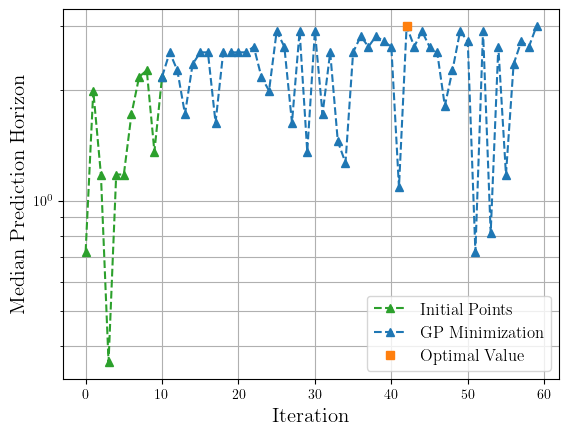

In [38]:
a = n_initial_points
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(func_iters.shape[0])

if a > 0:
    plt.semilogy(
        -func_iters[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, func_iters.shape[0])
plt.semilogy(
    xplot,
    -func_iters[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
plt.semilogy([optim_idx], [-func_iters[optim_idx]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Median Prediction Horizon', fontsize=15)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_rnn_plots+'/median_PH.pdf', bbox_inches='tight', dpi=300)
plt.show()

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

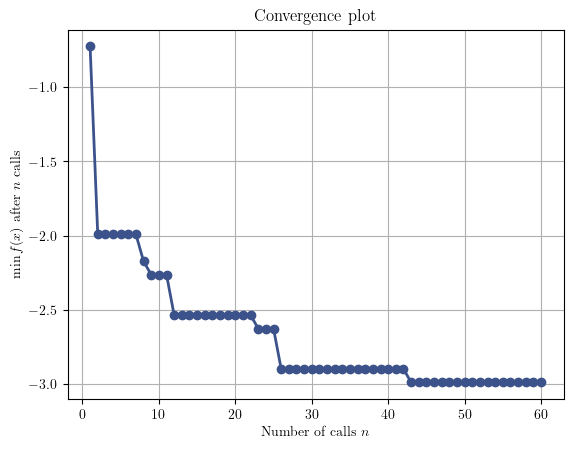

In [39]:
from skopt.plots import plot_convergence
plot_convergence(res)

In [40]:
optimized_vals_dict = {
    'x_iters':x_iters,
    'func_iters':func_iters,
    'optim_x':optim_x,
    'optim_idx':optim_idx,
    'optim_fun':func_iters[optim_idx]
}

with open(dir_name_rnn+'/optimized_vals.txt', 'w') as f:
    f.write(str(optimized_vals_dict))
    
np.savez(
    dir_name_rnn+'/optimized_vals',
    x_iters=x_iters,
    func_iters=func_iters,
    optim_x=optim_x,
    optim_idx=optim_idx,
    optim_fun=func_iters[optim_idx]
)

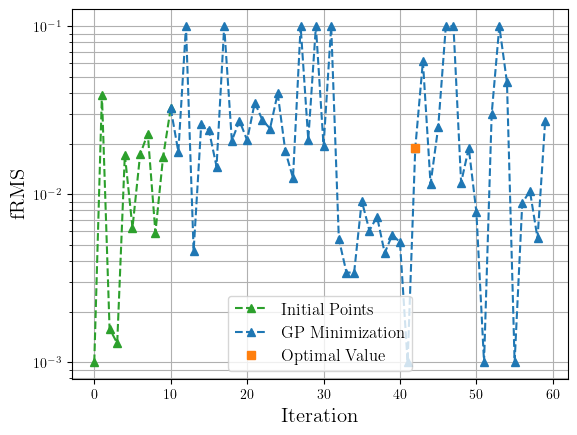

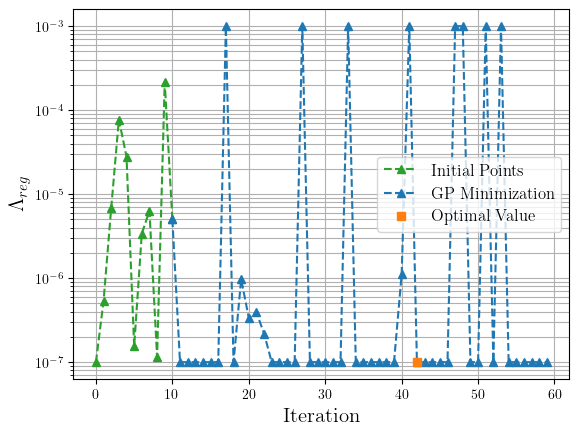

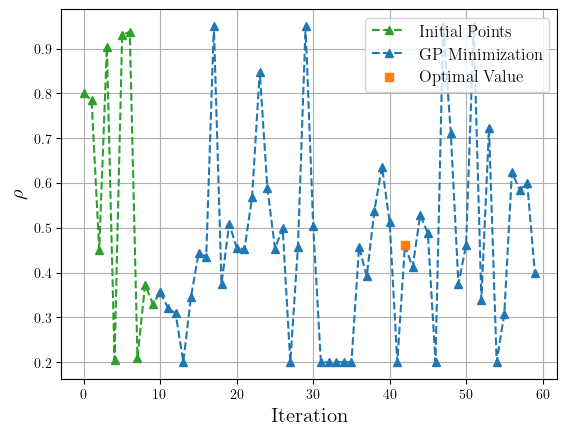

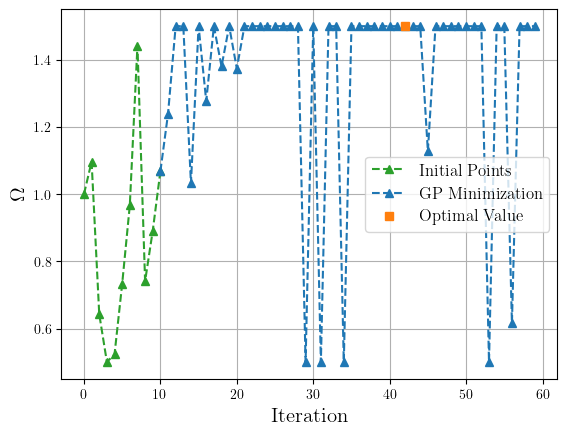

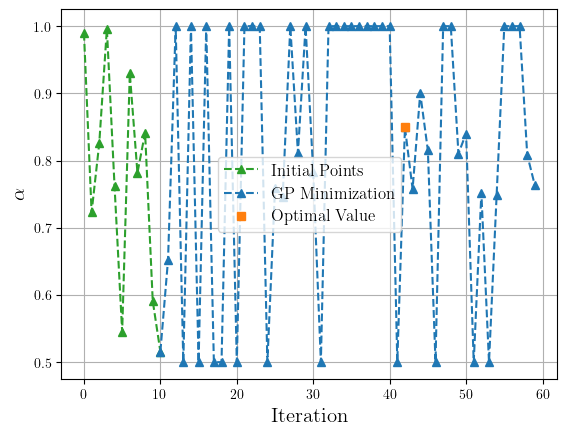

In [41]:
xoptim_names = [
    [r'fRMS', 'fRMS', plt.semilogy],
    [r'$\Lambda_{reg}$', 'lambda_reg', plt.semilogy],
    [r'$\rho$', 'rho', plt.plot],
    [r'$\Omega$', 'omega', plt.plot],
    [r'$\alpha$', 'alpha', plt.plot],
    # [r'Degree of Connectivity', 'deg_of_connectivity', plt.plot],
]
if vary_deg_connect == True:
    xoptim_names.append([r'Degree of Connectivity', 'deg_of_connectivity', plt.plot])

for i in range(len(xoptim_names)):
    a = n_initial_points
    # sorted_idx = np.argsort(x_iters[a:, 0])

    xplot = np.arange(x_iters.shape[0])
    if a > 0:
        xoptim_names[i][2](
            x_iters[:, i][0:a+1],
            linestyle='--',
            color='C2',
            marker='^',
            label='Initial Points',
        )
        xplot = np.arange(a, x_iters.shape[0])
    xoptim_names[i][2](
        xplot,
        x_iters[:, i][a:],
        linestyle='--',
        marker='^',
        label='GP Minimization',#'__nolegend__',
    )
    xoptim_names[i][2]([optim_idx], [x_iters[optim_idx, i]], 's', label='Optimal Value')

    plt.xlabel('Iteration', fontsize=15)
    plt.ylabel(xoptim_names[i][0], fontsize=15)
    plt.grid(True, which='major', axis='x')
    plt.grid(True, which='both', axis='y')
    plt.legend(fontsize=12)

    plt.savefig(dir_name_rnn_plots+'/'+xoptim_names[i][1]+'.pdf', bbox_inches='tight', dpi=300)
    plt.show()

In [42]:
dir_list = os.listdir(dir_name_rnn+'/tested_ESN')
# dir_list

In [43]:
ph_mean_lst = []
for dir_name in dir_list:
    with np.load(dir_name_rnn+'/tested_ESN/'+dir_name+'/prediction_horizons-testingdata.npz') as f:
        ph_mean = np.mean(f['prediction_horizon_arr'])
        ph_mean_lst.append(ph_mean)
ph_mean_lst = np.array(ph_mean_lst)

In [44]:
idx = np.where(ph_mean_lst == ph_mean_lst.max())[0]

In [45]:
idx, dir_list[idx[0]]

(array([30]), 'test_ESN_052')

In [46]:
# convergence plot
convergence_f = np.empty_like(func_iters)
min_val = np.inf
for i in range(func_iters.shape[0]):
    if func_iters[i] < min_val:
        min_val = func_iters[i]
    convergence_f[i] = min_val

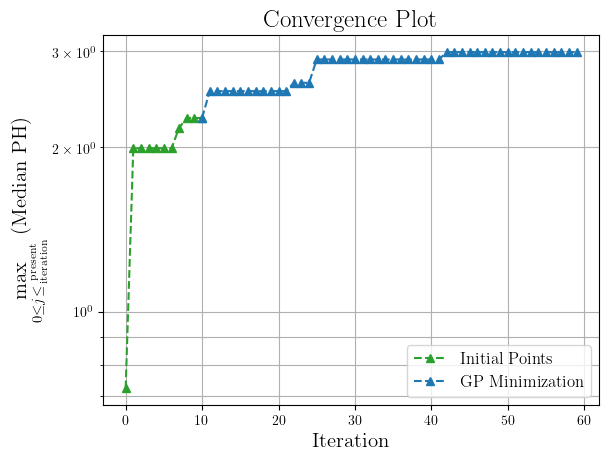

In [47]:
a = n_initial_points
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(x_iters.shape[0])

if a > 0:
    plt.semilogy(
        -convergence_f[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, x_iters.shape[0])
plt.semilogy(
    xplot,
    -convergence_f[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
# plt.semilogy([optim_idx], [func_iters[optim_idx, 0]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel(
#     r"$$\min_{0 \leq j \leq \mathrm{present \ iteration}} \left( \mathrm{Test \ MSE} \right)$$",
#     r"$$\min_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Test \ MSE} \right)$$",
    r"$$\max_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Median \ PH} \right)$$",
    fontsize=15,
)
plt.title('Convergence Plot', fontsize=18)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_rnn_plots+'/convergence_plot.pdf', bbox_inches='tight', dpi=300)
plt.show()

### Prediction horizon computation